In [1]:
# Step 1: Install required libraries
!pip install transformers accelerate torch torchvision


In [2]:
# STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# STEP 3: Unrar your images (adjust path as needed)
!apt-get install unrar > /dev/null 2>&1

import os

rar_path = '/content/drive/MyDrive/images.zip'  # <-- change this
extract_dir = '/content/images'

os.makedirs(extract_dir, exist_ok=True)
!unrar x -o+ "{rar_path}" "{extract_dir}/"



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/images.zip

Extracting  /content/images/28.png                                         0%  OK 
Extracting  /content/images/29.png                                         1%  OK 
Extracting  /content/images/30.png                                         2%  OK 
Extracting  /content/images/31.png                                         3%  OK 
Extracting  /content/images/32.png                                         4%  OK 
Extracting  /content/images/33.png                                         5%  OK 
Extracting  /content/images/34.png                                         6%  OK 
Extracting  /content/images/35.png                                         6%  OK 
Extracting  /content/images/36.png                                         7%  OK 
Extracting  /content/images/37.png           

In [4]:
import glob
import os
import random
import logging
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from transformers import AutoProcessor, InstructBlipForConditionalGeneration
import torch

# Set up logging for any image processing errors
logging.basicConfig(level=logging.ERROR)

# STEP 1: Get all .png images from the extracted folder
image_paths = sorted(
    glob.glob(os.path.join(extract_dir, "*.png")),
    key=lambda x: int(os.path.basename(x).split(".")[0])
)
selected_images = random.sample(image_paths, min(10, len(image_paths)))

# STEP 2: Load InstructBLIP processor & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")
model = InstructBlipForConditionalGeneration.from_pretrained(
    "Salesforce/instructblip-flan-t5-xl",
    torch_dtype=torch.float16,
)


model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

InstructBlipForConditionalGeneration(
  (vision_model): InstructBlipVisionModel(
    (embeddings): InstructBlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): InstructBlipEncoder(
      (layers): ModuleList(
        (0-38): 39 x InstructBlipEncoderLayer(
          (self_attn): InstructBlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): InstructBlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        

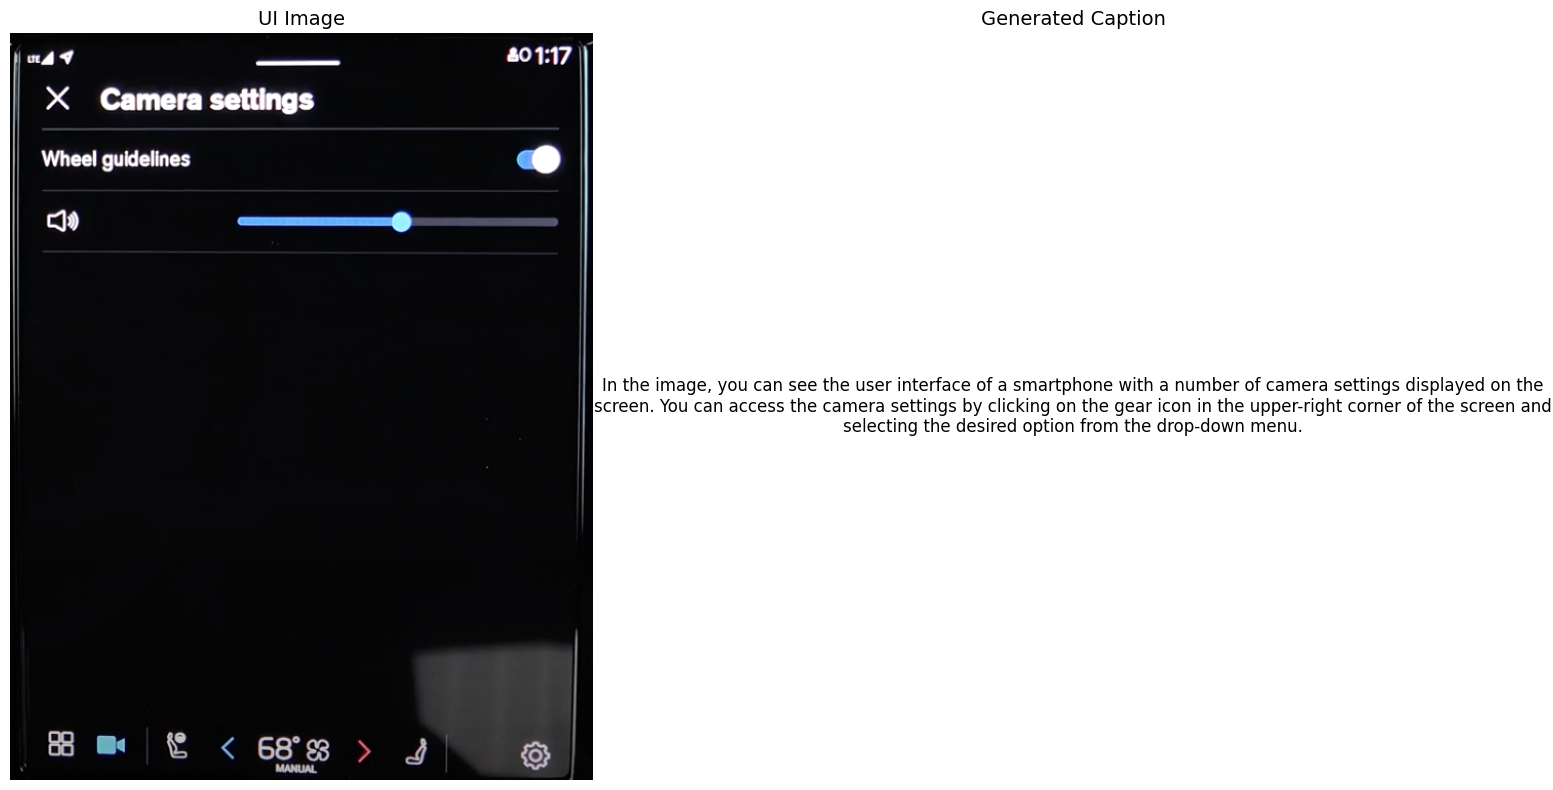

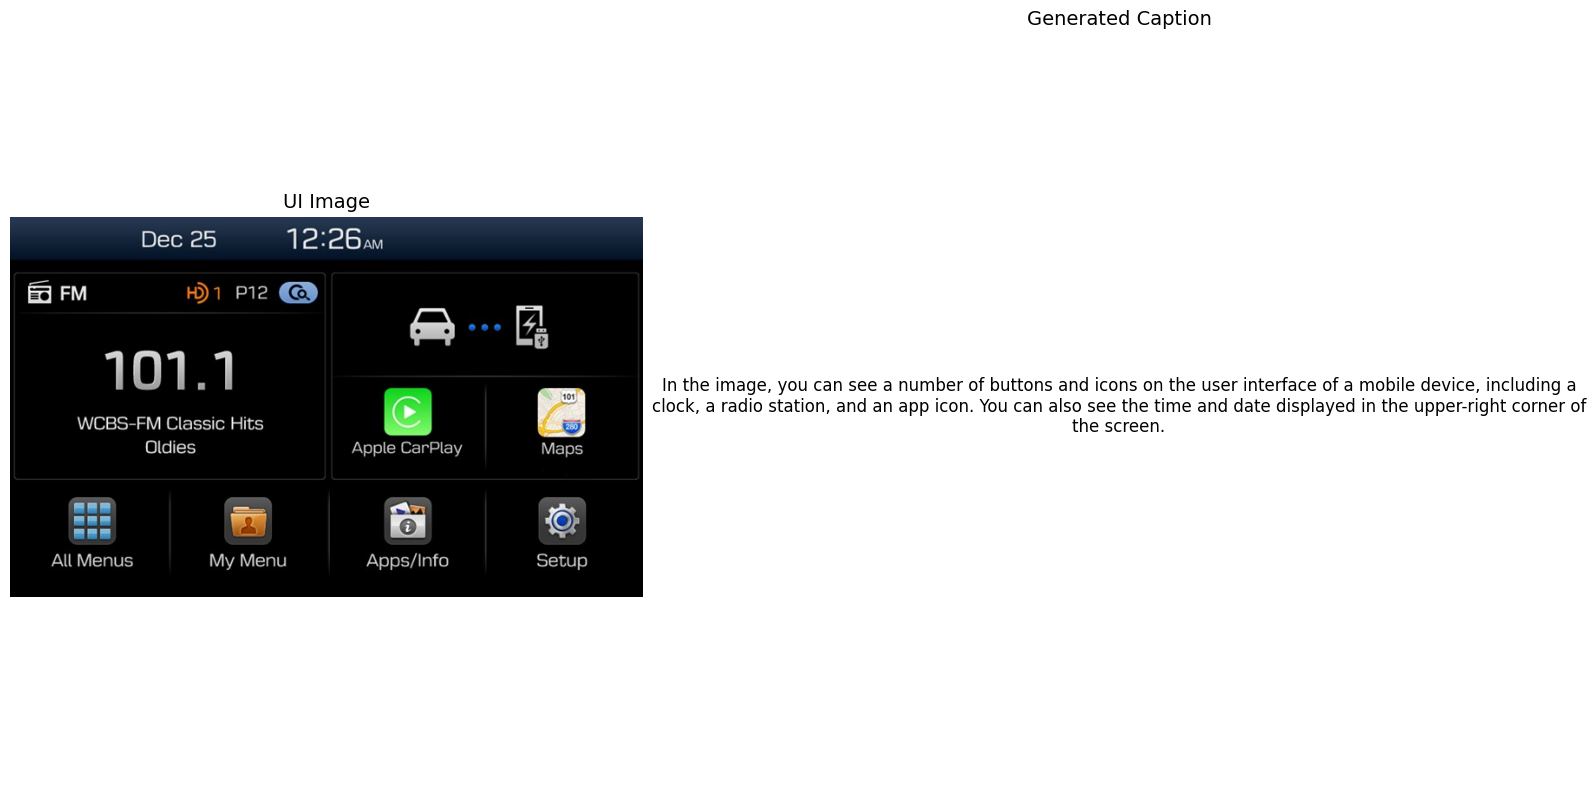

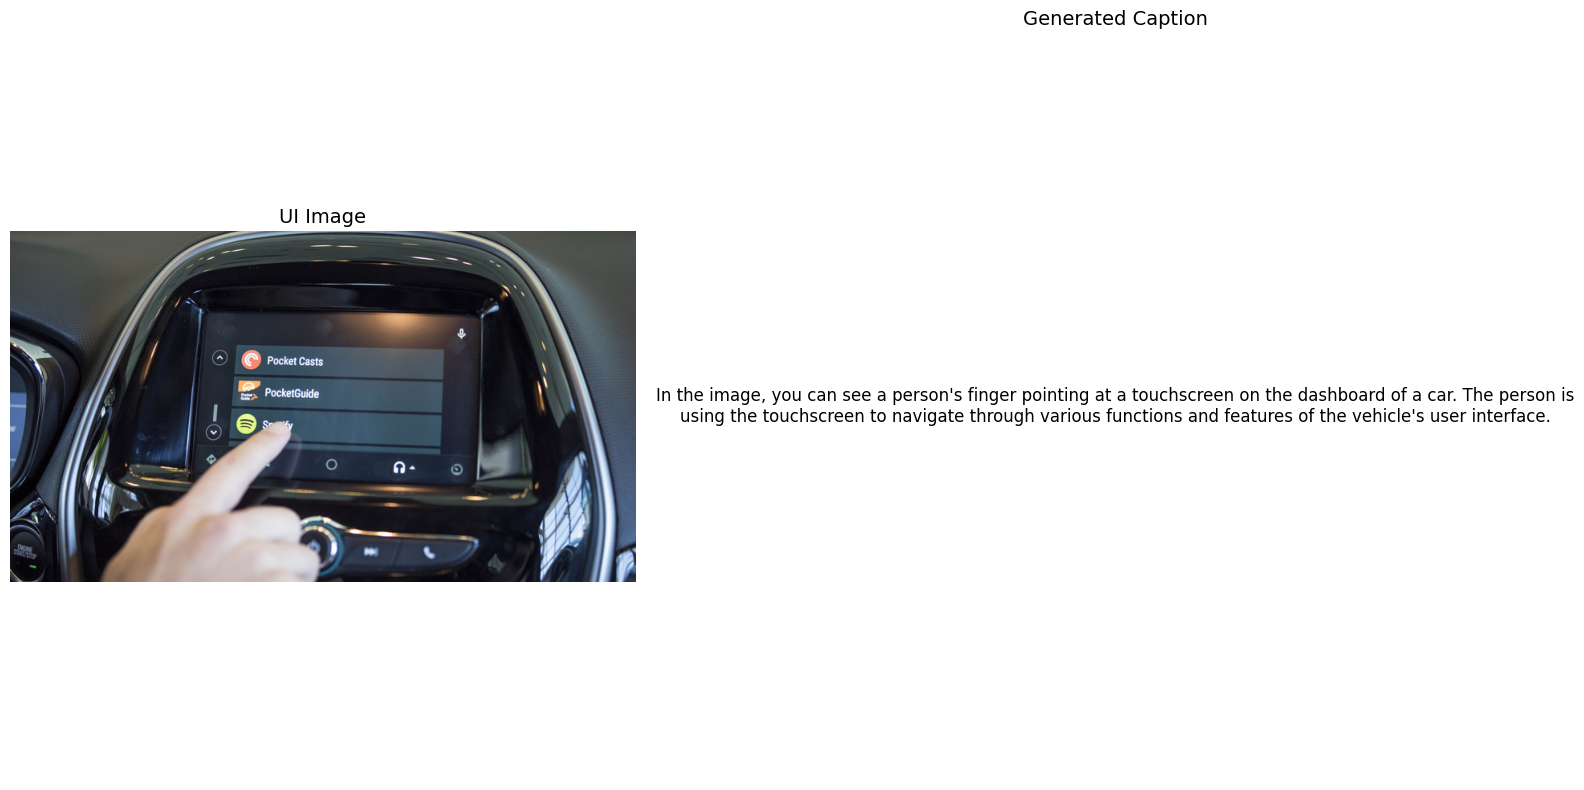

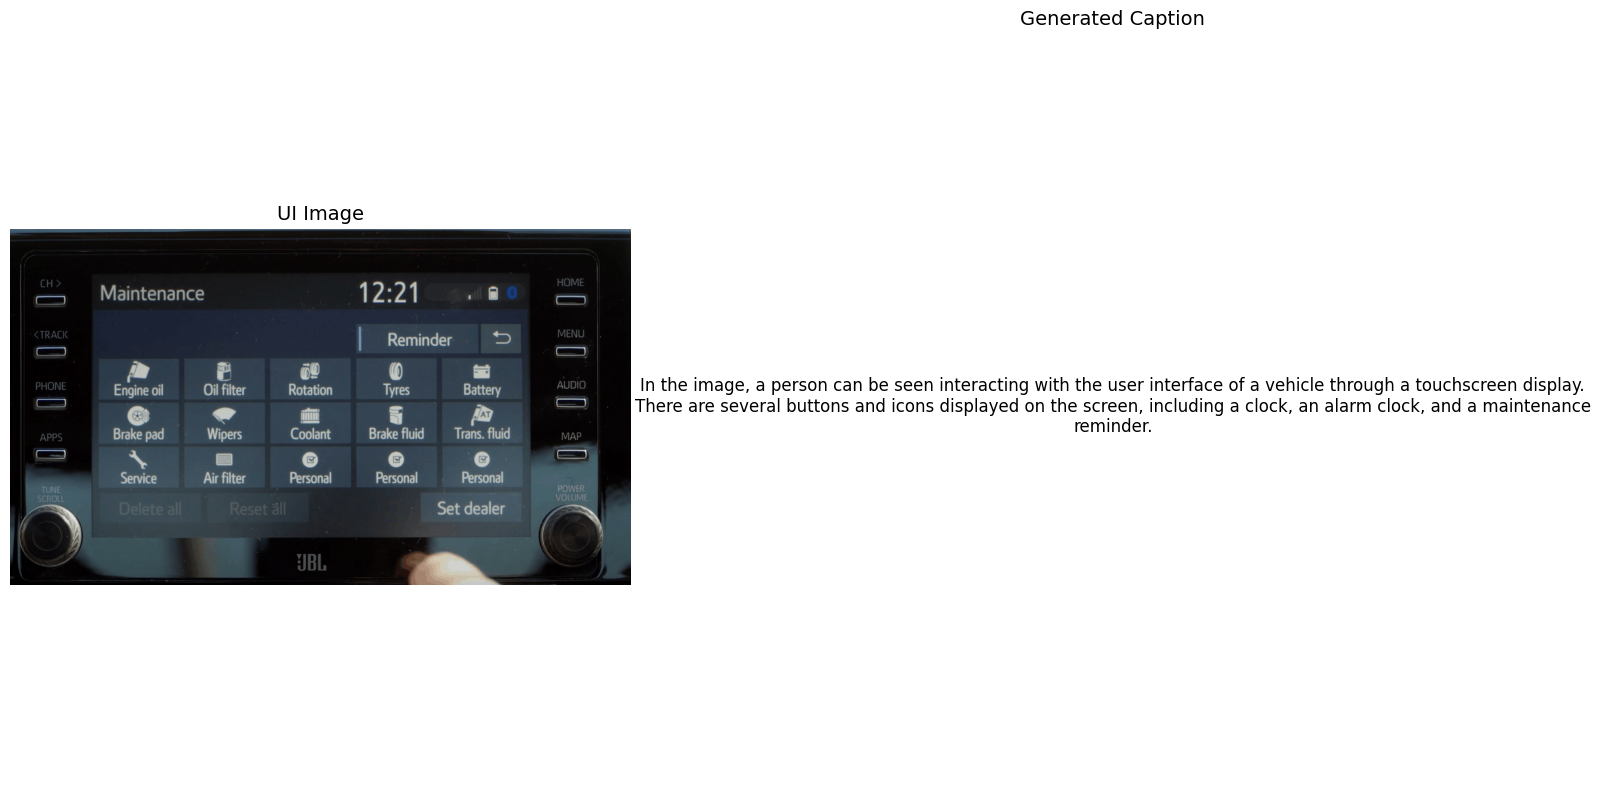

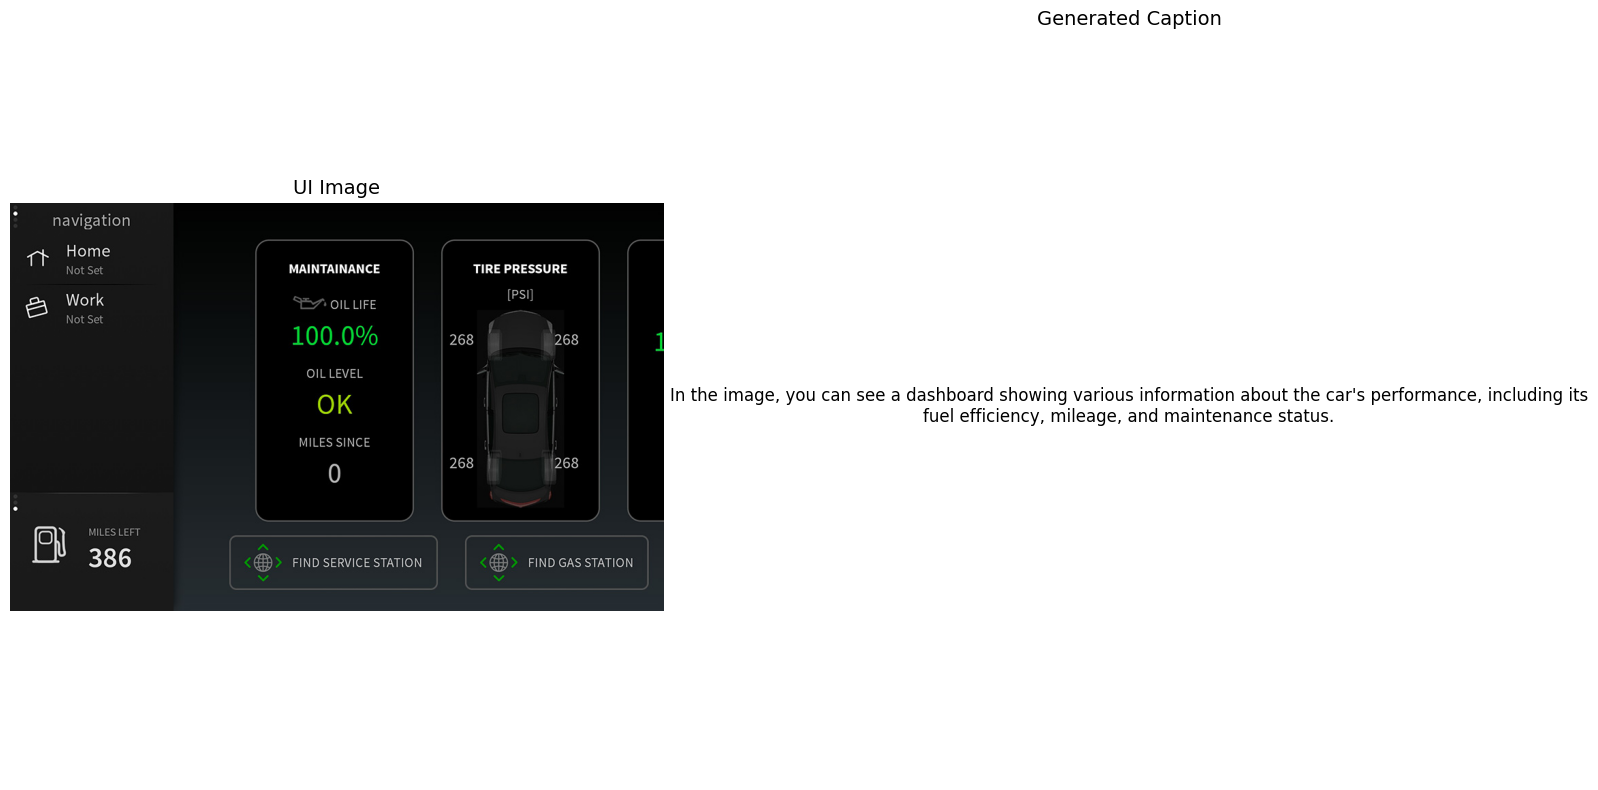

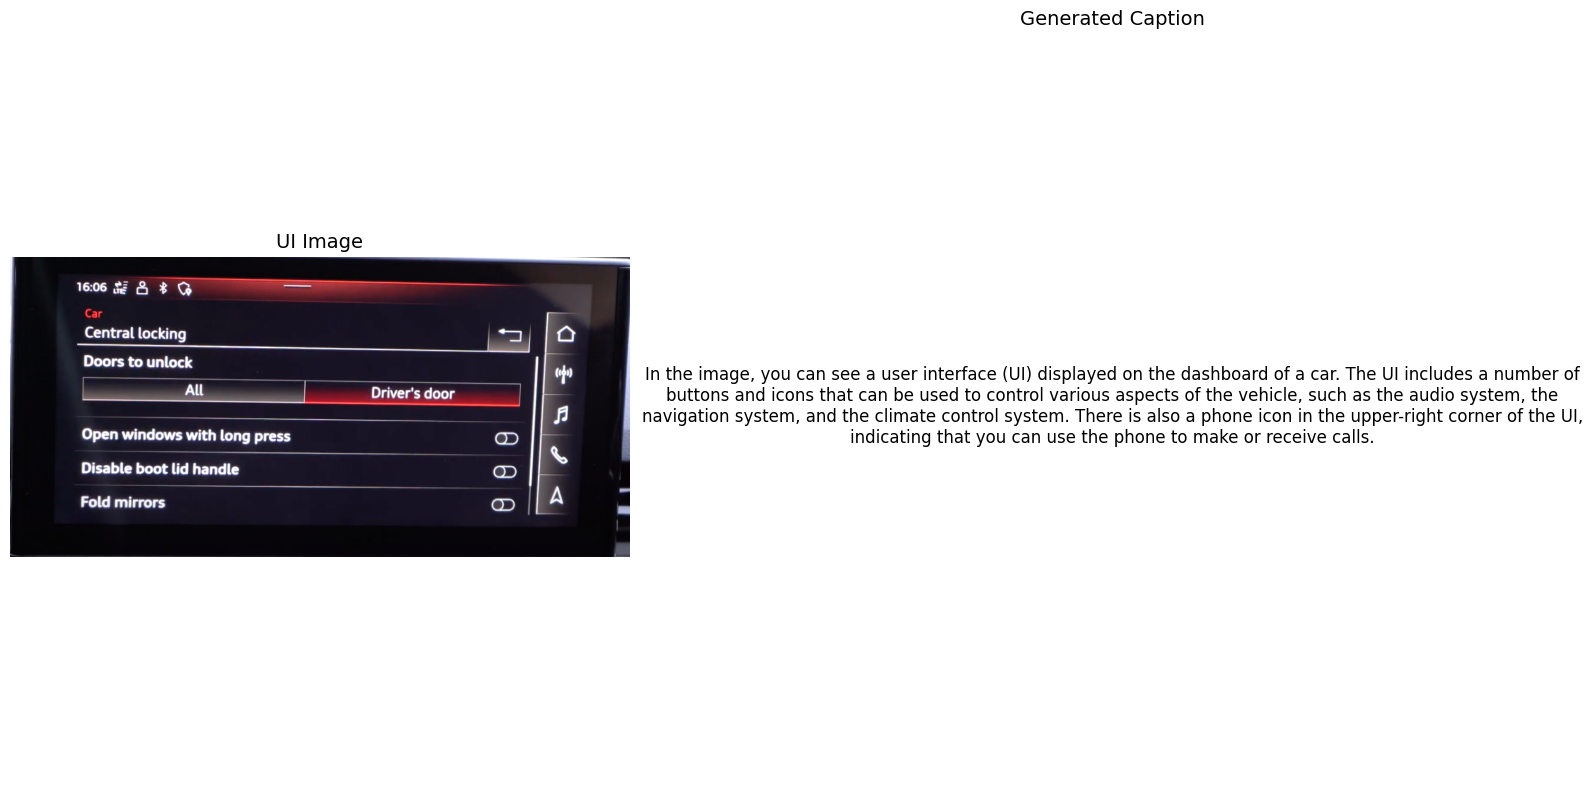

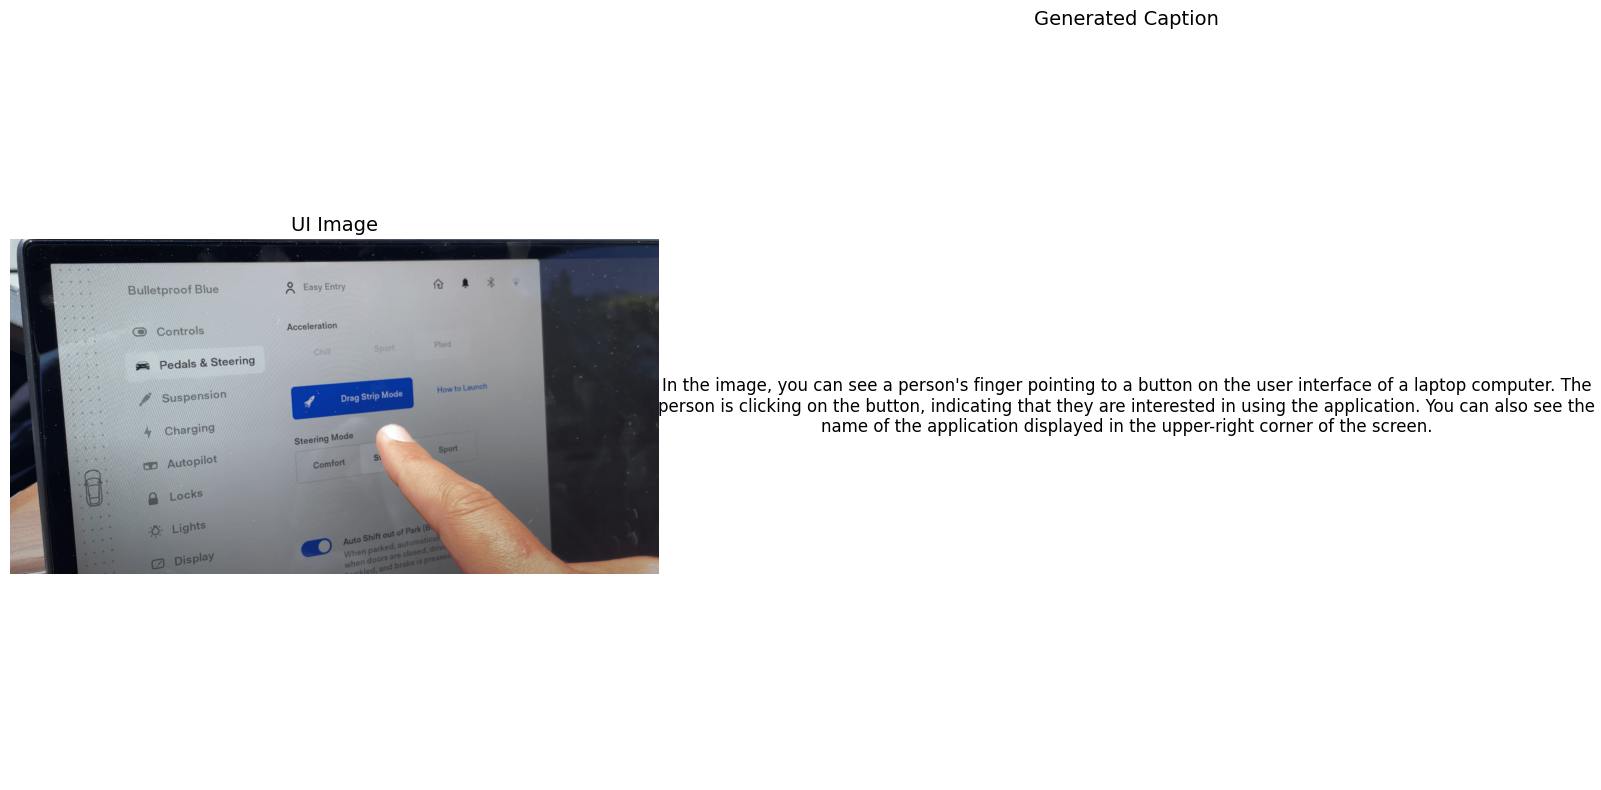

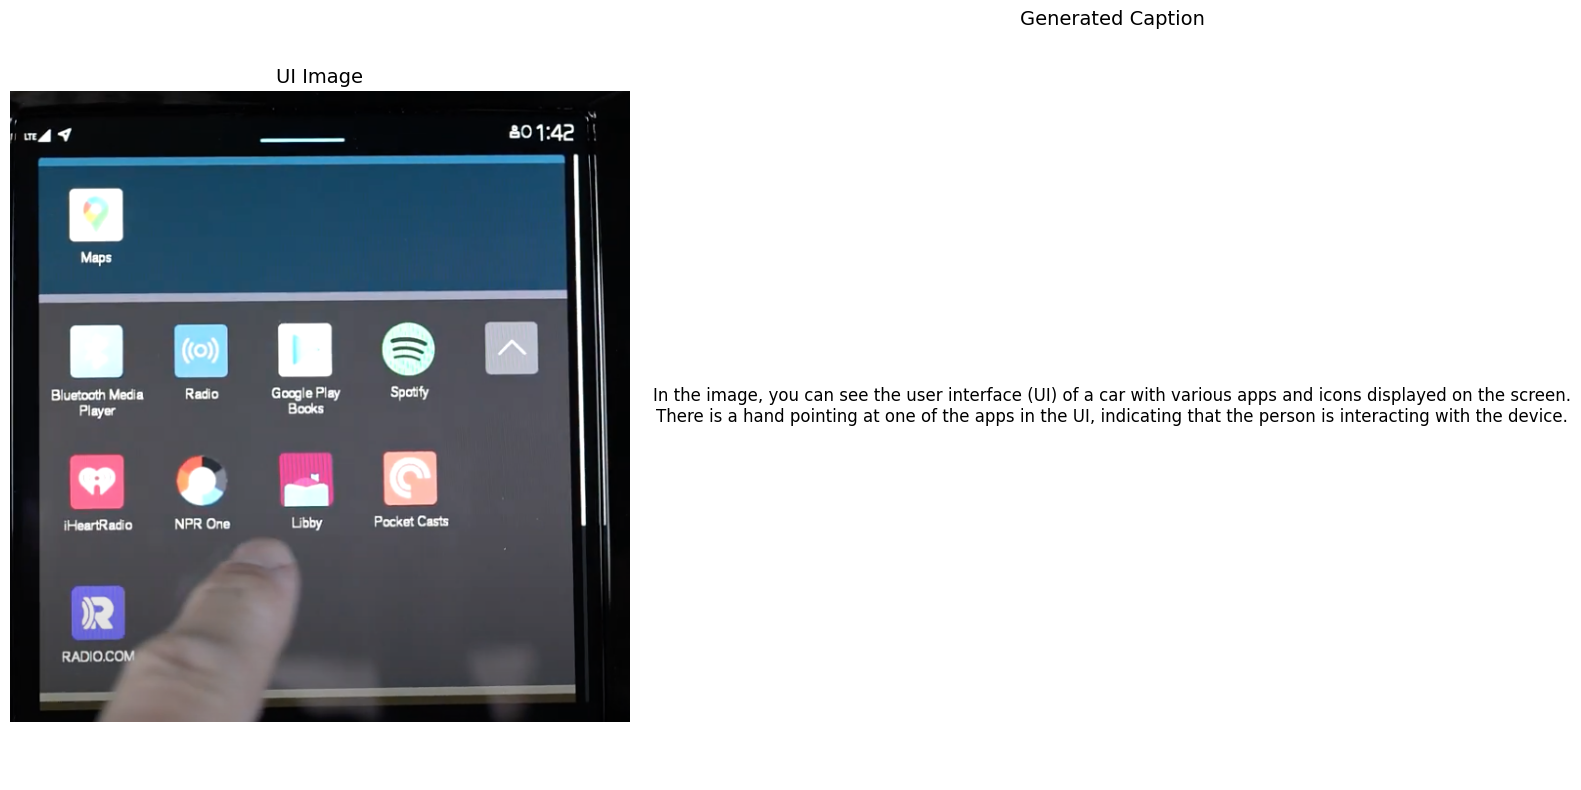

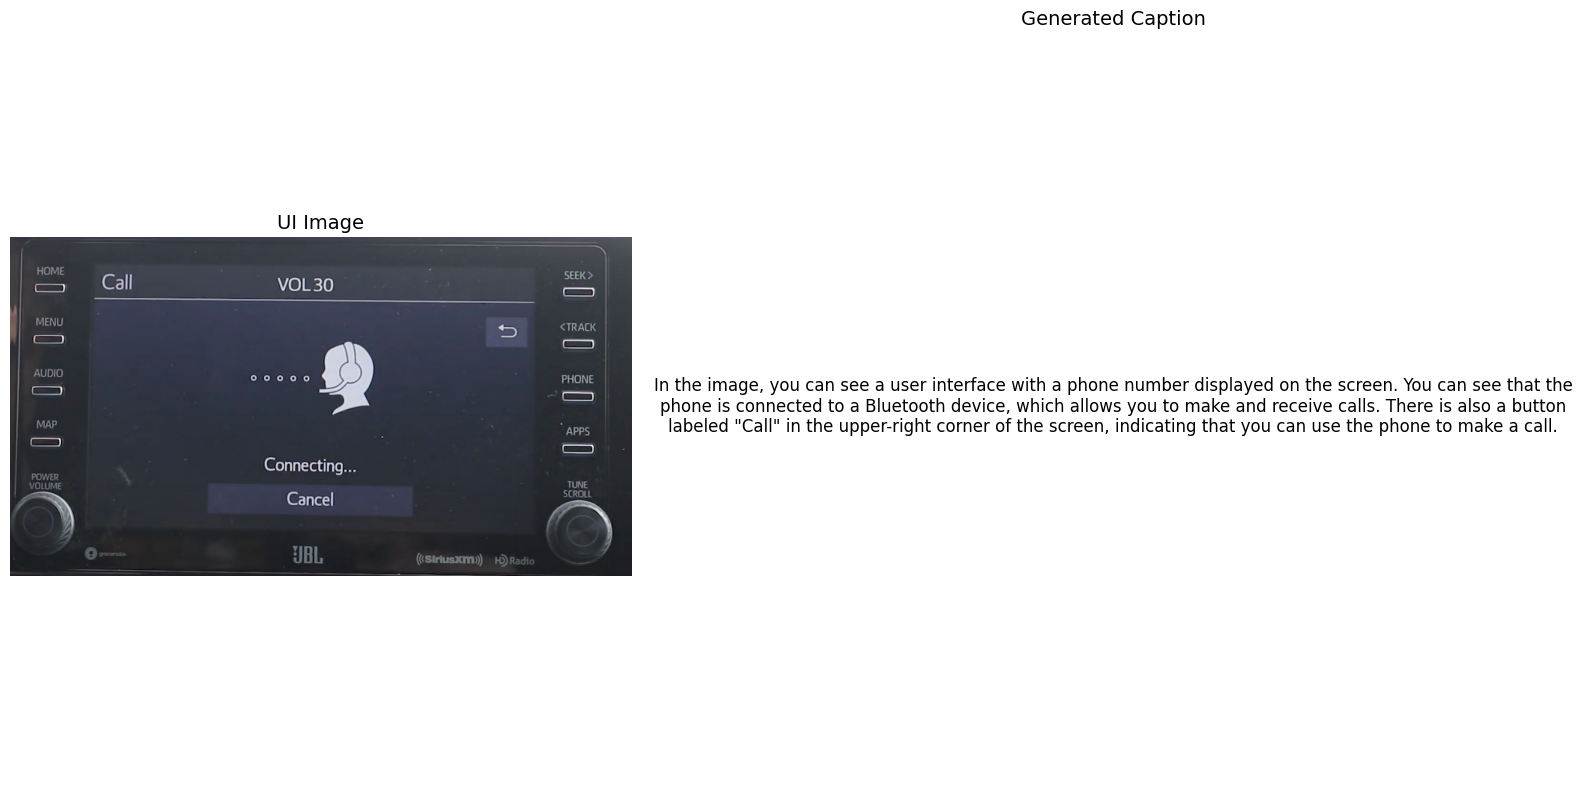

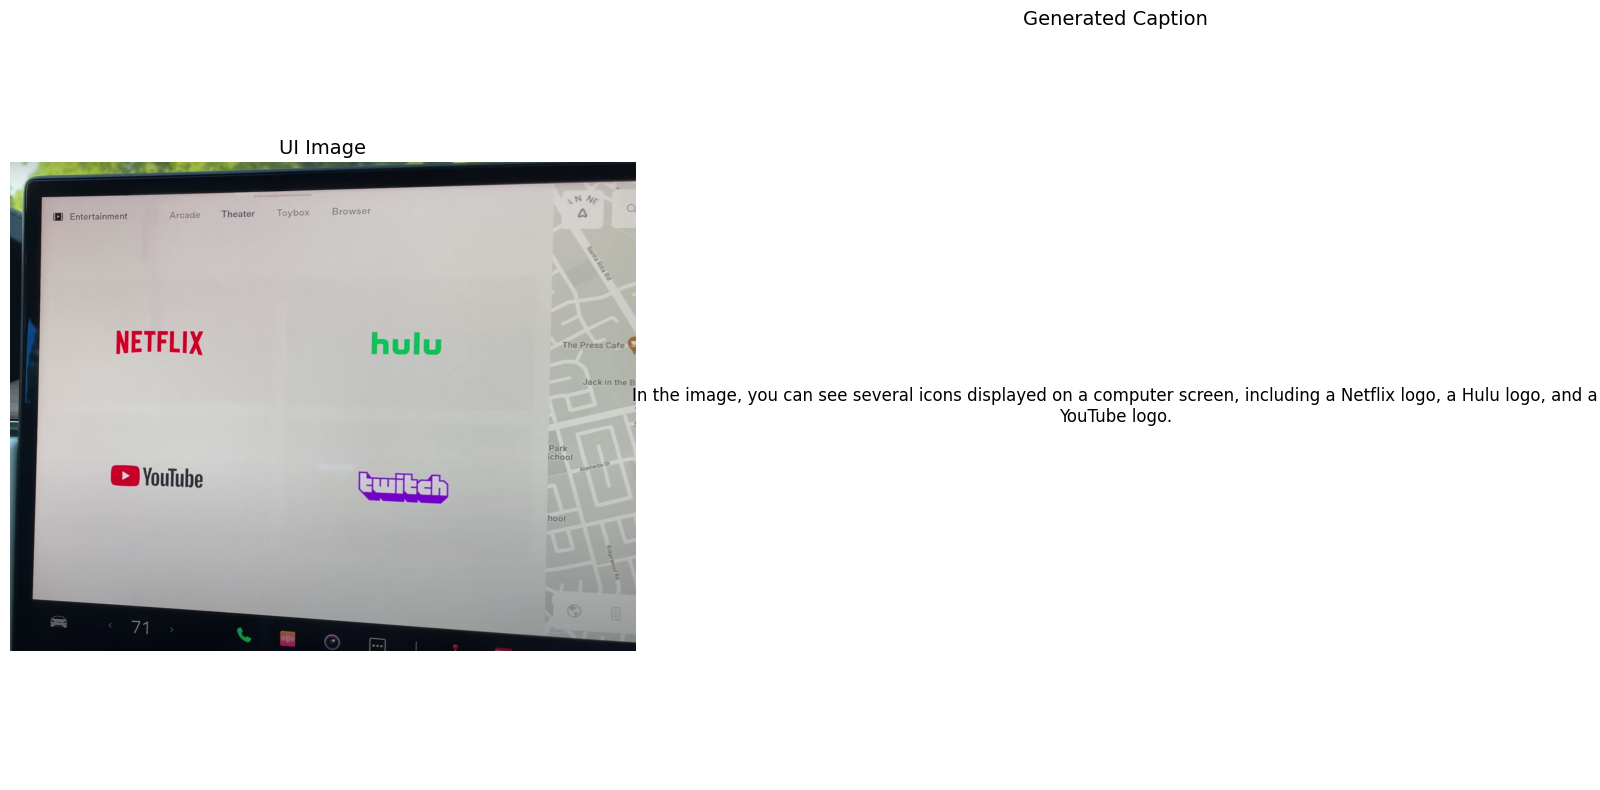

In [5]:
import gc  # garbage collector
import torch

# STEP 3: Generate captions for each image
for img_path in selected_images:
    try:
        raw_image = Image.open(img_path).convert("RGB")

        prompt = "What can you see in the the User Interface?"

        # Preprocess
        inputs = processor(images=raw_image, text=prompt, return_tensors="pt").to(device)

        # Generate
        output = model.generate(
            **inputs,
            max_new_tokens=200,
            num_beams=20,
            early_stopping=True,
            no_repeat_ngram_size=3,
            repetition_penalty=1.3,
            do_sample=True,
            top_k=50,
            top_p=0.7,
            temperature=0.8
        )

        caption = processor.tokenizer.decode(output[0], skip_special_tokens=True)
        if caption.lower() == prompt.lower():
            caption = "No meaningful caption generated. Try using different prompt settings."

        # Display
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        axs[0].imshow(raw_image)
        axs[0].axis("off")
        axs[0].set_title("UI Image", fontsize=14)
        axs[1].text(0.5, 0.5, caption, fontsize=12, ha="center", va="center", wrap=True)
        axs[1].axis("off")
        axs[1].set_title("Generated Caption", fontsize=14)
        plt.tight_layout()
        plt.show()

    except UnidentifiedImageError as e:
        logging.error(f"Could not open or process image: {img_path}. Error: {e}")
        continue

    finally:
        # 🧹 Free memory
        del raw_image, inputs, output, caption
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
